### Track ML experiment using PyTorch

#### Setup PyTorch DataLoader

In [12]:
import wandb
import random
import math
import torch, torchvision
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

In [13]:
MNIST.mirrors = [mirror for mirror in MNIST.mirrors if "http://yann.lecun.com/" not in mirror]

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [15]:
def get_dataloader(is_train, batch_size, slice=5):
    "Get a training dataloader"
    full_dataset = MNIST(root=".", train=is_train, transform=T.ToTensor(), download=True)
    sub_dataset = torch.utils.data.Subset(full_dataset, indices=range(0, len(full_dataset), slice))
    loader = torch.utils.data.DataLoader(dataset=sub_dataset,
                                         batch_size=batch_size,
                                         shuffle=True if is_train else False,
                                         pin_memory=True, num_workers=2)
    return loader

In [16]:
def get_model(dropout):
    "A simple model"
    model = nn.Sequential(nn.Flatten(),
                         nn.Linear(28*28, 256),
                         nn.BatchNorm1d(256),
                         nn.ReLU(),
                         nn.Dropout(dropout),
                         nn.Linear(256,10)).to(device)
    return model

In [17]:
def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)

            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images, predicted, labels, outputs.softmax(dim=1))
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)

#### Create a wandb table to compare predicted values verus the true value

In [18]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

In [19]:
# Launch 3 experiments, trying different dropout rates

for _ in range(3):
    # initialise a wandb run
    wandb.init(
        project="pytorch-intro",
        config={
            "epochs": 5,
            "batch_size": 128,
            "lr": 1e-3,
            "dropout": random.uniform(0.01, 0.80),
            })

    # Copy your config
    config = wandb.config

    # Get the data
    train_dl = get_dataloader(is_train=True, batch_size=config.batch_size)
    valid_dl = get_dataloader(is_train=False, batch_size=2*config.batch_size)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple MLP model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

   # Training
    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        model.train()
        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {"train/train_loss": train_loss,
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                       "train/example_ct": example_ct}

            if step + 1 < n_steps_per_epoch:
                # Log train metrics to wandb
                wandb.log(metrics)

            step_ct += 1

        val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=(epoch==(config.epochs-1)))

        # Log train and validation metrics to wandb
        val_metrics = {"val/val_loss": val_loss,
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})

        # Save the model checkpoint to wandb
        torch.save(model, "my_model.pt")
        wandb.log_model("./my_model.pt", "my_mnist_model", aliases=[f"epoch-{epoch+1}_dropout-{round(wandb.config.dropout, 4)}"])

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # If you had a test set, this is how you could log it as a Summary metric
    wandb.summary['test_accuracy'] = 0.8

    # Close your wandb run
    wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: paul-mriganka (paul-mriganka-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 9912422/9912422 [00:00<00:00, 40519884.61it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1110012.77it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 10287295.22it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2196532.78it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Epoch: 1, Train Loss: 0.353, Valid Loss: 0.311085, Accuracy: 0.91
Epoch: 2, Train Loss: 0.374, Valid Loss: 0.251247, Accuracy: 0.93
Epoch: 3, Train Loss: 0.227, Valid Loss: 0.219894, Accuracy: 0.93
Epoch: 4, Train Loss: 0.217, Valid Loss: 0.204576, Accuracy: 0.93
Epoch: 5, Train Loss: 0.189, Valid Loss: 0.191753, Accuracy: 0.94


train/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/example_ct,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
train/train_loss,█▅▅▅▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▂
val/val_accuracy,▁▅▆▇█
val/val_loss,█▄▃▂▁
test_accuracy,0.8
train/epoch,5
train/example_ct,60000
train/train_loss,0.18908
val/val_accuracy,0.936
val/val_loss,0.19175


Epoch: 1, Train Loss: 0.242, Valid Loss: 0.304676, Accuracy: 0.92
Epoch: 2, Train Loss: 0.282, Valid Loss: 0.252600, Accuracy: 0.93
Epoch: 3, Train Loss: 0.167, Valid Loss: 0.216940, Accuracy: 0.93
Epoch: 4, Train Loss: 0.202, Valid Loss: 0.200428, Accuracy: 0.94
Epoch: 5, Train Loss: 0.236, Valid Loss: 0.191115, Accuracy: 0.94


train/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇█
train/example_ct,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇████
train/train_loss,█▆▅▅▅▄▄▃▅▃▄▄▃▂▃▂▂▂▂▃▃▄▂▂▄▃▂▂▂▂▃▂▂▃▁▂▁▂▁▂
val/val_accuracy,▁▄▆█▇
val/val_loss,█▅▃▂▁
test_accuracy,0.8
train/epoch,5
train/example_ct,60000
train/train_loss,0.23561
val/val_accuracy,0.9355
val/val_loss,0.19111


Epoch: 1, Train Loss: 0.331, Valid Loss: 0.289033, Accuracy: 0.92
Epoch: 2, Train Loss: 0.291, Valid Loss: 0.242169, Accuracy: 0.93
Epoch: 3, Train Loss: 0.184, Valid Loss: 0.209349, Accuracy: 0.93
Epoch: 4, Train Loss: 0.093, Valid Loss: 0.185548, Accuracy: 0.94
Epoch: 5, Train Loss: 0.120, Valid Loss: 0.172554, Accuracy: 0.94


train/epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
train/example_ct,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
train/train_loss,█▇▆▆▃▂▃▂▂▂▂▁▂▂▂▂▁▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▄▅▇█
val/val_loss,█▅▃▂▁
test_accuracy,0.8
train/epoch,5
train/example_ct,60000
train/train_loss,0.11955
val/val_accuracy,0.945
val/val_loss,0.17255


### Outputs

#### Preedictions Table

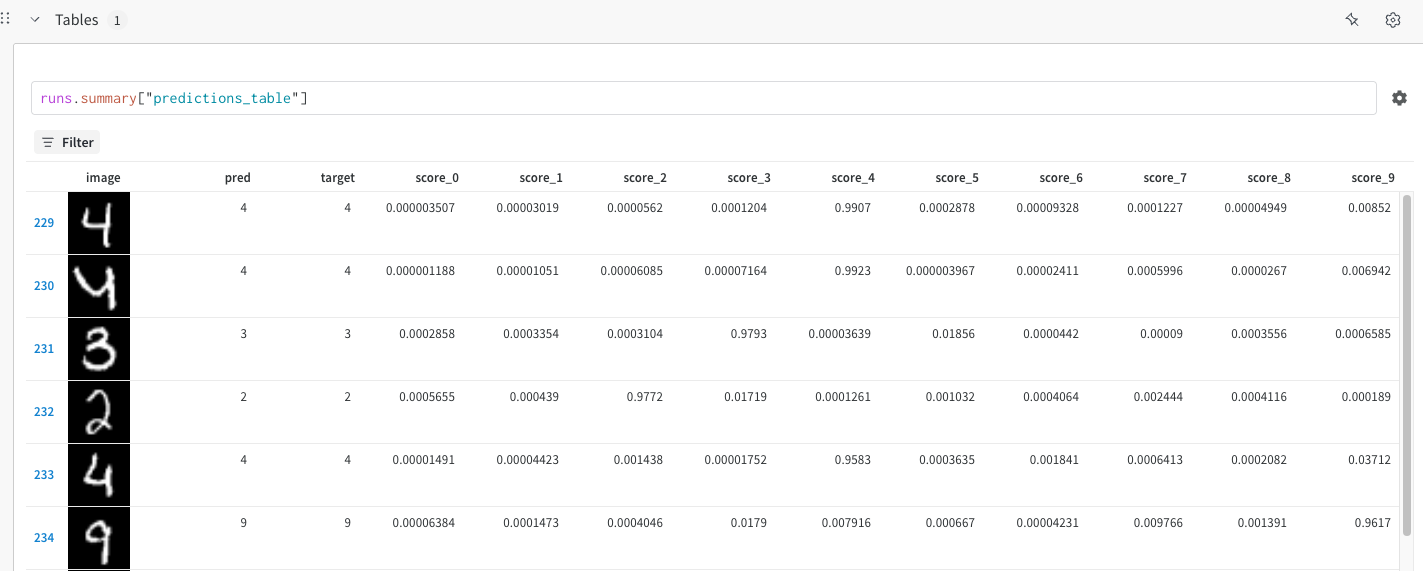

#### Metrices

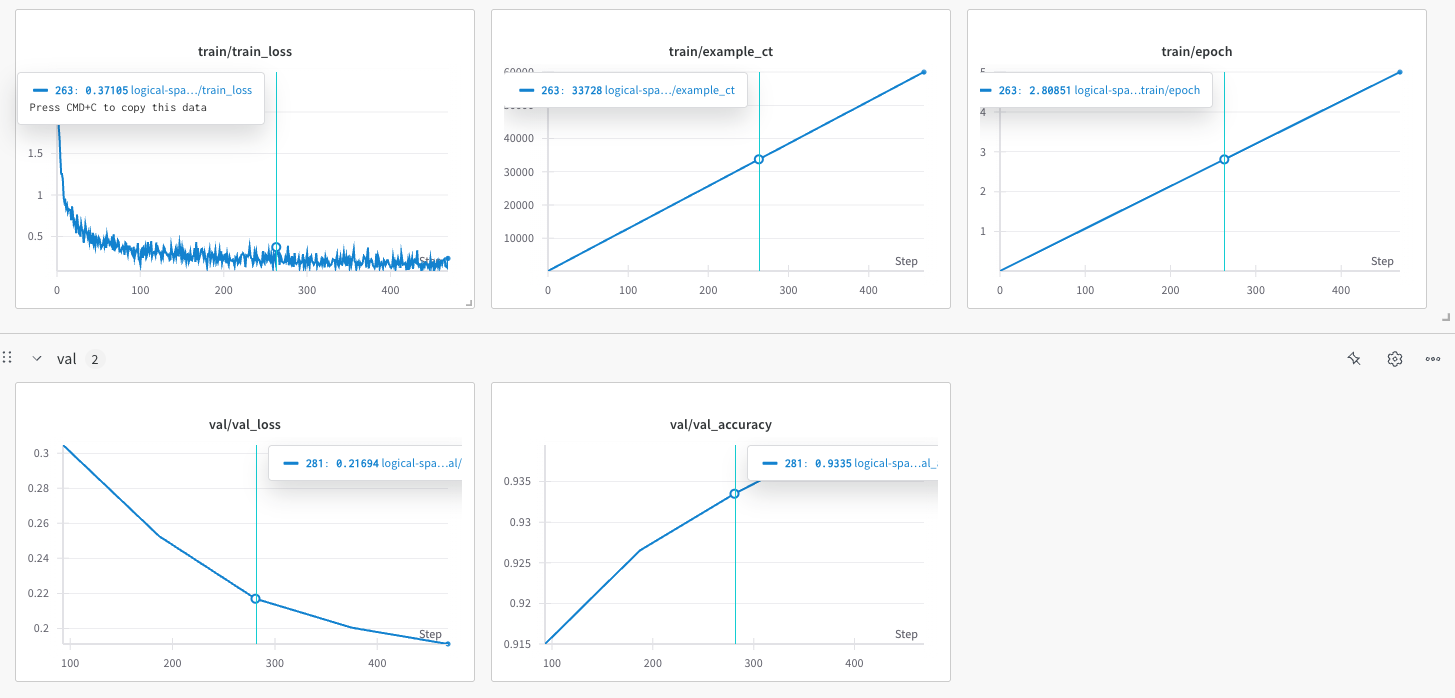

#### Artifacts

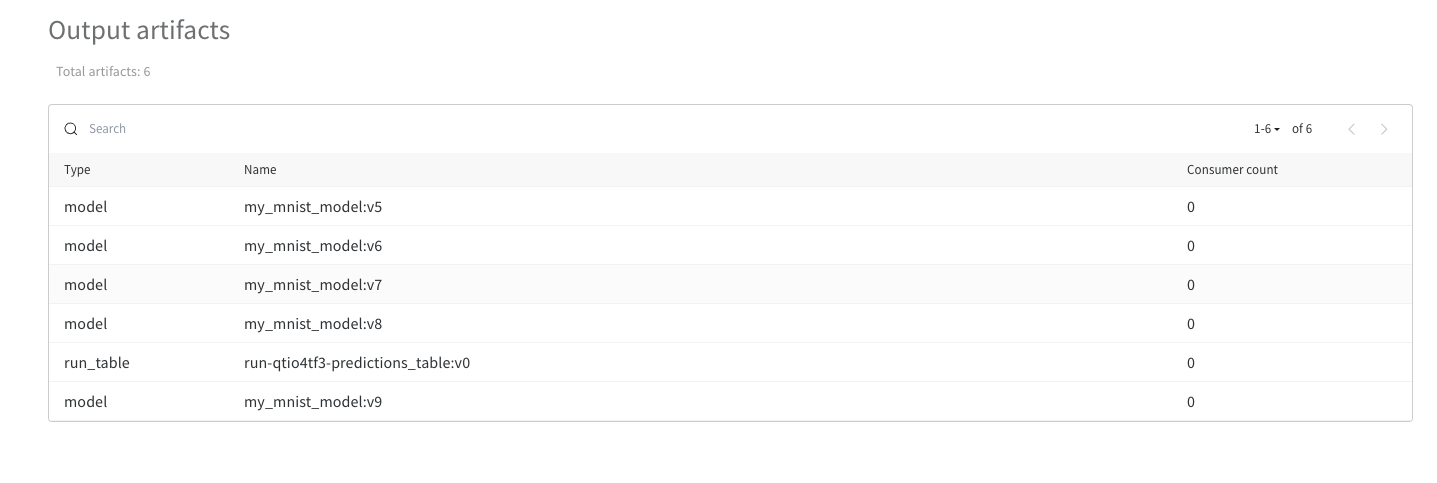

#### Logs

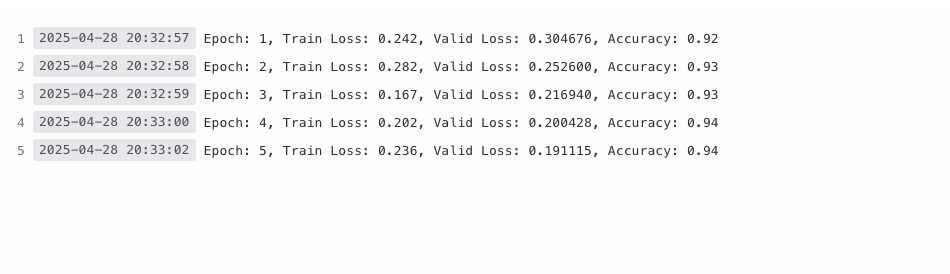